# Instituto Tecnológico y de Estudios Superiores de Occidente
### Master in Data Science
### Modelos Gráficos probabilísticos

### **Predicción del tipo de retraso para vuelos**


**Fecha:**  16 de Julio del 2022

**Profesor:** Esteban Jiménez Rodriguez

**Nombre:** Jesús Rodrigo Ponce González
___

<img src="https://image.cnbcfm.com/api/v1/image/107083340-1656616608324-passengers.jpg?v=1656683955&w=740&h=416"/>

# Introducción
Las aerolíneas han cancelado más de 1,100 vuelos desde el viernes pasado y más de 12,000 fueron retrasados. Solo para la semana pasada, los retrasos estuvieron cerca de 1,000 para American Airlines y 784 Delta. Los vuelos retrasados el sábado disminuyeron sin embargo llegaron hasta los 5,000. En lo que va del año, el porcentaje de vuelos cancelados y retrasado para junio ha sido mayor que antes de la pandemia causados por el mal clima y bajo personal.

Hace dos semanas, la aerolínea Delta decidió permitir a los pasajeros cambiar sus vuelos gratuitamente, si viajaban después del fin de semana del 4 de Julio. JetBlue Airways ofreció bonos de asistencia para los sobrecargos este verano para tener personal sólido. American Airlines está ofreciendo triple paga a los pilotos que decidan tomar vuelos extras hasta julio.

Aproximadamente 176,000 vuelos aterrizaron al menos 15 minutos tarde entre el 1ero de junio y 29 de junio. Esto representa más del 23% de los vuelos agendados, y más 20,000 - casi 3% - fueron cancelados.

Esto es más del 20% de vuelos retrasados y 2% siendo cancelados en el mismo periodo del 2019.

## Propuesta

Un vuelo retrasado desencadena una serie de problemas para la aerolínas así como para los pasajeros. En este *notebook* se busca predecir estos vuelos retrasados usando una base de datos obtenida de harvard, estos vuelos son de Dallas. La predicción de los vuelos retrasados inicialmente se hará con una red Bayesiana, la cual se estará comparando con dos modelos adicionales; Naive Bayes y un clasificador Random Forest.

Las diferentes métricas que se usarán para su comparación serán:
- Accuracy
- Cohen’s Kappa
- Coeficiente de correlación de Matthew

Datos originales: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/HG7NV7

## Exploración de datos

In [516]:
from pgmpy.models import BayesianNetwork
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
sns.set(style = 'darkgrid')
sns.set_palette('magma_r')

In [517]:
%run 'data_cleaning.py'

Forma original del dataset: (1936758, 29)
El sample tiene la forma de:  (964184, 9)


## Limpieza y análisis de base de datos

La base de datos contiene 1936758 filas y 29 columnas. Con propósitos de simplicidad y eficiencia, se obtuvo una muestra de la base de datos y se estará usando la ubicación con más vuelos retrasados: *'William B Hartsfield-Atlanta Intl' in Atlanta*
Para esta base de datos se creó una nueva variable 'Departure Delay Type'(DepDelayType) la cual asume que se tiene un vuelo retrasado. Esta variable está dividida en tres categorías:
1. Small Delay - Retraso menor a 15 minutos
2. Medium Delay - Retraso mayor a 15 minutos y menor a 45 minutos
3. Large Delay - Retraso mayor a 45 minutos

Los vuelos con un número de vuelo menor suelen tener más retrasos


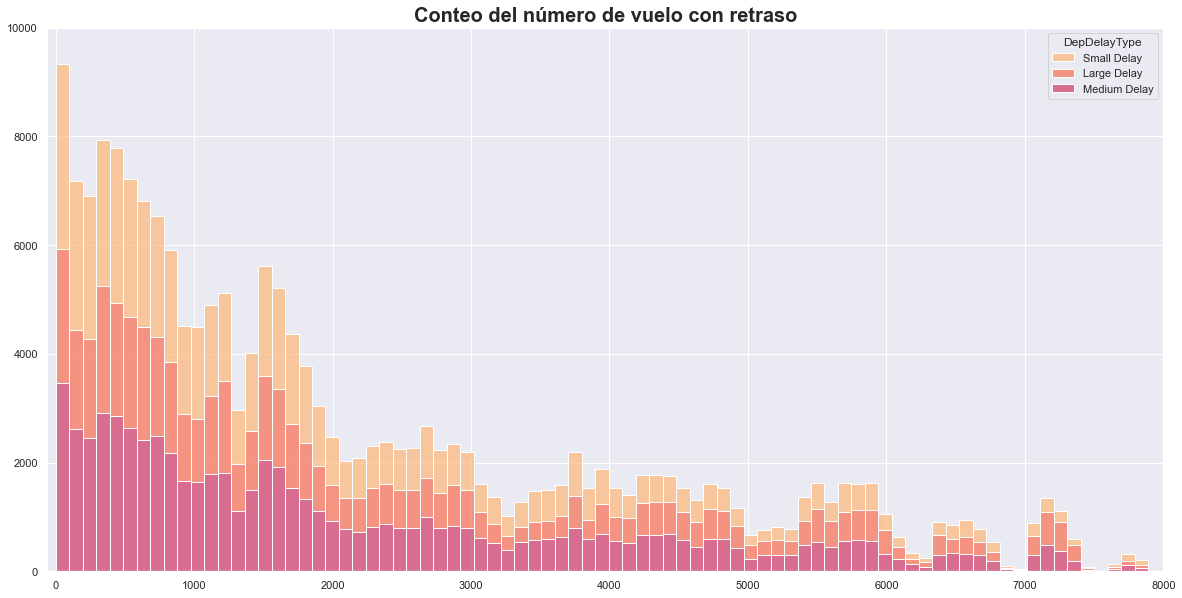

In [518]:
# Count of FlightNumbers hue with DelayType
plt.figure(figsize=(20,10))
ax = sns.histplot(data = df_sample, x = 'FlightNum', kde= False, stat = 'count', multiple = 'stack', hue = 'DepDelayType')
ax.set_ylabel('')
ax.set_title('Conteo del número de vuelo con retraso', fontsize=20, fontweight = 'bold')
plt.xlim(-60,8000)
plt.ylim(0,10000)
ax.set_xlabel('')
print('Los vuelos con un número de vuelo menor suelen tener más retrasos')

Se tienen más vuelos de tipo mediano:  mayor 15 y menor a 45


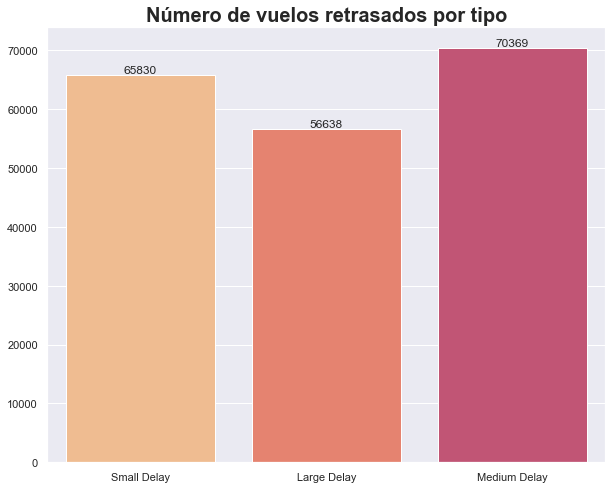

In [519]:
# Count of delays per Delay Type
plt.figure(figsize=(10,8))
ax = sns.countplot(x = df_sample['DepDelayType'])
for container in ax.containers:
    ax.bar_label(container)
ax.set_ylabel('')
ax.set_title('Número de vuelos retrasados por tipo', fontsize = 20, fontweight = 'bold')
ax.set_xlabel('')
print('Se tienen más vuelos de tipo mediano:  mayor 15 y menor a 45')

No se ve una tendencia clara en el número de vuelos retrasados mensualmente


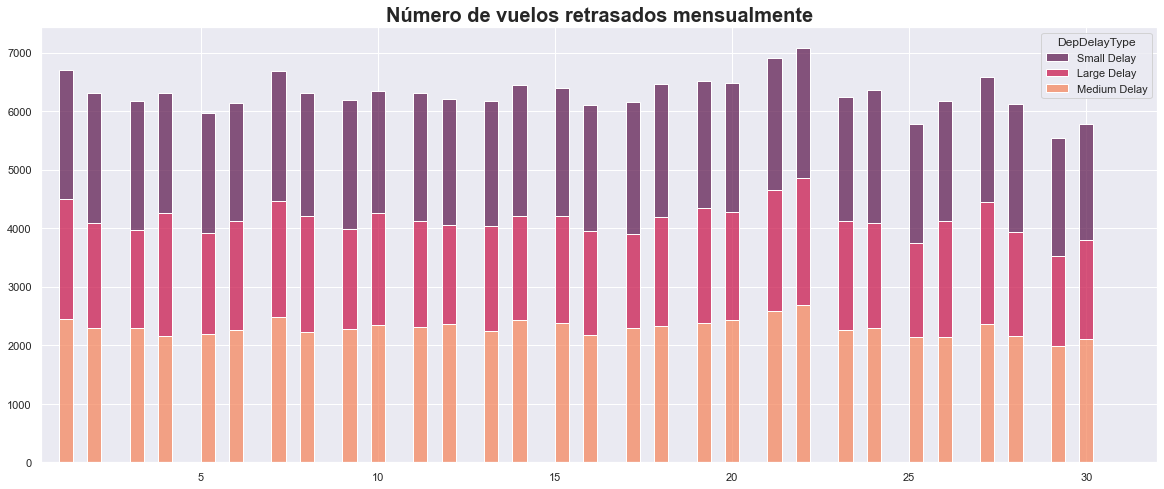

In [520]:
plt.figure(figsize=(20,8))
ax = sns.histplot(data = df_sample, stat = 'count', x = 'DayofMonth', hue = 'DepDelayType', multiple = 'stack', palette = 'rocket', binwidth = 0.4)
ax.set_ylabel('')
plt.xlim(0.5,32)
ax.set_title('Número de vuelos retrasados mensualmente', fontsize = 20, fontweight = 'bold')
ax.set_xlabel('')
print('No se ve una tendencia clara en el número de vuelos retrasados mensualmente')

Los sábados tienen un menor número de vuelos retrasados, mientras que los viernes y lunes son los días con más retrasos


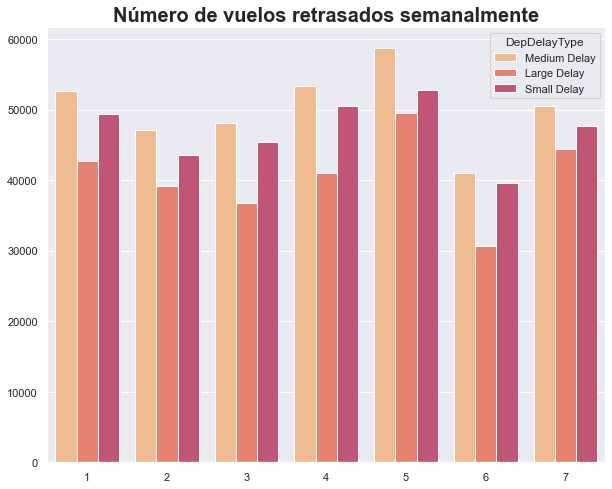

In [521]:
plt.figure(figsize=(10,8))
ax = sns.countplot(data = df_deps_sample, x = 'DayOfWeek', hue = 'DepDelayType')
ax.set_ylabel('')
ax.set_title('Número de vuelos retrasados semanalmente', fontsize = 20, fontweight = 'bold')
ax.set_xlabel('')
print('Los sábados tienen un menor número de vuelos retrasados, mientras que los viernes y lunes son los días con más retrasos')

In [522]:
df_sample

,Month,DayofMonth,DayOfWeek,CRSDepTime,UniqueCarrier,Origin,Dest,Distance,DepDelayType,FlightNum
0,1,3,4,1955,WN,133,282,810,Small Delay,335
26,1,3,4,1255,WN,140,104,1093,Large Delay,188
48,1,3,4,1435,WN,145,48,888,Small Delay,3244
52,1,3,4,1940,WN,145,130,359,Medium Delay,3154
118,1,3,4,1200,WN,152,64,1772,Small Delay,991
...,...,...,...,...,...,...,...,...,...,...
7009445,12,13,6,1555,DL,267,18,445,Large Delay,1198
7009468,12,13,6,1122,DL,260,268,588,Large Delay,1223
7009469,12,13,6,1255,DL,264,264,588,Large Delay,1224
7009666,12,13,6,950,DL,18,210,516,Medium Delay,1554


Las distribuciones no son normales


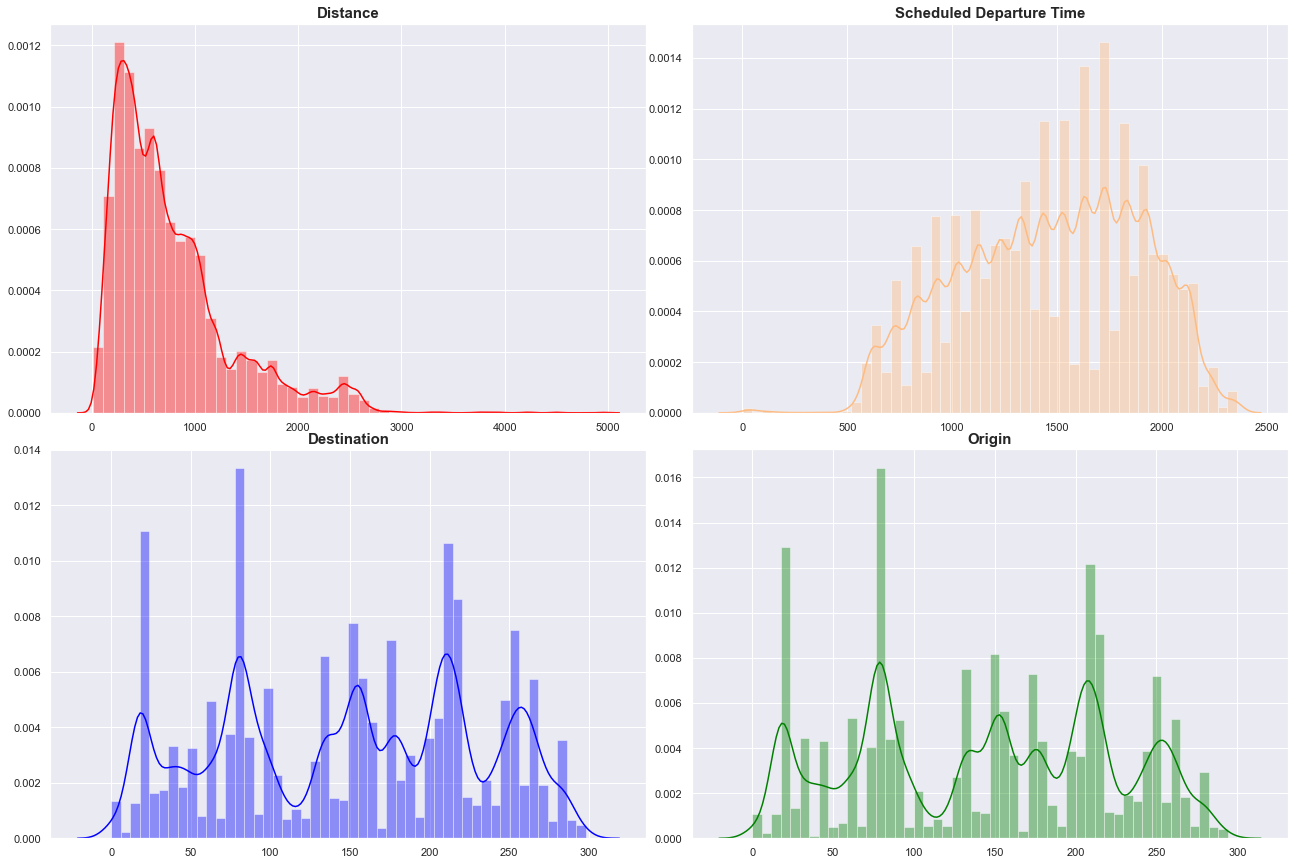

In [523]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(18, 12)
fig.tight_layout()
sns.distplot(x = df_sample['Distance'], ax = axes[0,0], color = 'red')
sns.distplot(x = df_sample['CRSDepTime'], ax = axes[0,1])
sns.distplot(x = df_sample['Dest'], ax = axes[1,0], color = 'blue')
sns.distplot(x = df_sample['Origin'], ax = axes[1,1], color = 'green')

axes[0, 0].set_title("Distance", fontsize = 15, fontweight = 'bold')
axes[0, 0].set_ylabel('')
axes[0, 1].set_title("Scheduled Departure Time", fontsize = 15, fontweight = 'bold')
axes[0, 1].set_ylabel('')
axes[1, 0].set_title("Destination", fontsize = 15, fontweight = 'bold')
axes[1, 0].set_ylabel('')
axes[1, 1].set_title("Origin", fontsize = 15, fontweight = 'bold')
axes[1, 1].set_ylabel('')

print('Las distribuciones no son normales')


El método de clustermap usa clusteres jerárquicos para ordenar los datos por similitud. Esto reorganiza los datos por filas y columnas y muestra contenido similar uno a lado del otro para obtener un mejor entendimiento de los datos.

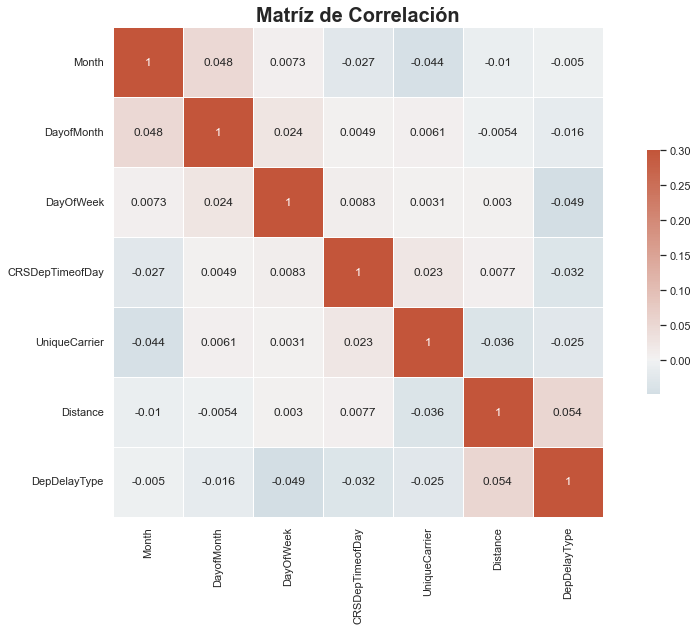

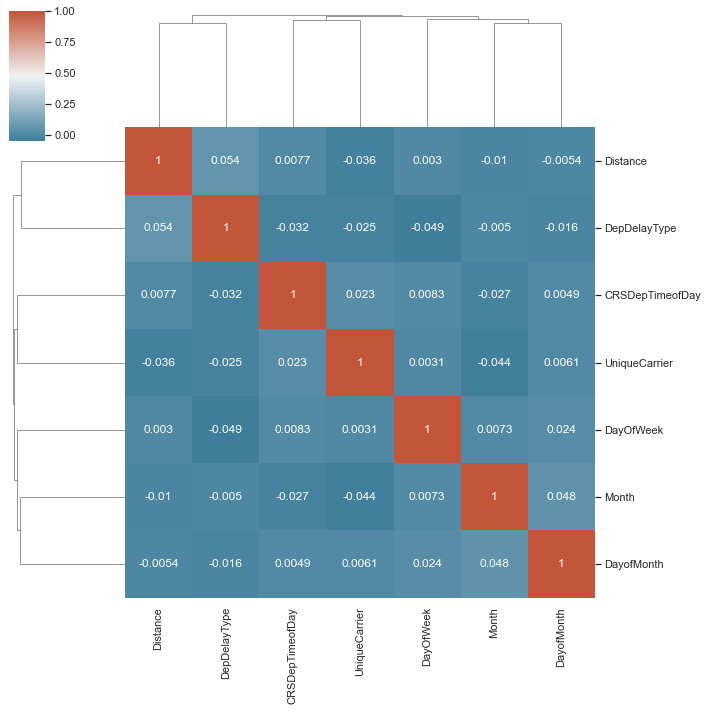

In [524]:
# Compute the correlation matrix
corr = df_deps_ATL.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(corr,  cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)
ax.set_title('Matríz de Correlación', fontsize = 20, fontweight = 'bold')

# Draw the clustermap
sns.clustermap(corr, xticklabels= corr.columns, yticklabels= corr.columns, annot=True, cmap = cmap)

## Train and Split

In [525]:
# Split de datos en train y test 
train = df_deps_ATL.sample(frac=0.7)
test = df_deps_ATL[~df_deps_ATL.index.isin(train.index)]

## Modelo 1: Bayesian Model

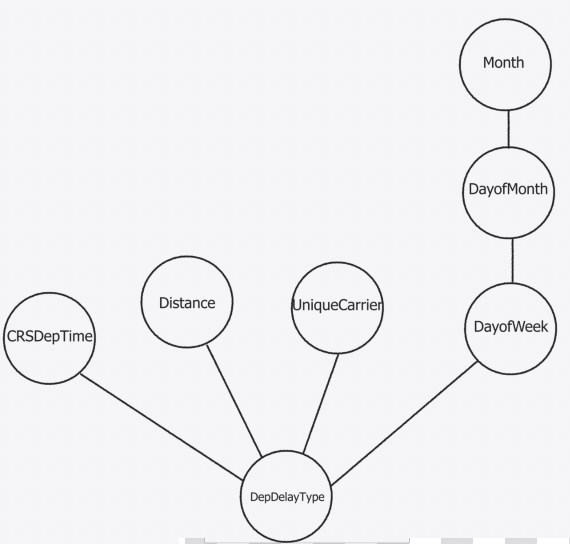

In [526]:
from IPython.display import Image
Image('airplane_bayes_network.png')

In [527]:
Bayesian_model = BayesianNetwork([
    ('Month','DayofMonth'),
    ('DayofMonth', 'DayOfWeek'),
    ('DayOfWeek','DepDelayType'),
    ('UniqueCarrier','DepDelayType'),
    ('Distance','DepDelayType'),
    ('CRSDepTimeofDay','DepDelayType'),])

In [528]:
# Entrenando el modelo
Bayesian_model.fit(train)

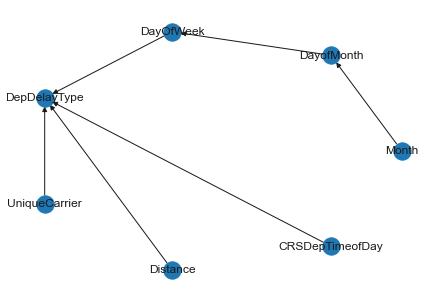

In [529]:
# Bayesian Network
pos = nx.circular_layout(Bayesian_model)
nx.draw(Bayesian_model, with_labels=True, pos=pos)
plt.show()

In [530]:
# Predicción
test['prediction'] = Bayesian_model.predict(test.drop(columns=['DepDelayType'])).values.ravel()
test.head()

  0%|          | 0/8919 [00:00<?, ?it/s]

,Month,DayofMonth,DayOfWeek,CRSDepTimeofDay,UniqueCarrier,Distance,DepDelayType,prediction
1,1,1,2,1,13,2,0,2
3,1,5,6,3,13,2,2,0
6,1,6,7,1,13,2,2,1
9,1,4,5,3,14,2,0,0
12,1,8,2,0,14,1,0,0


,0,1,2
0,1330,3112,933
1,1278,4249,1896
2,965,3729,2145


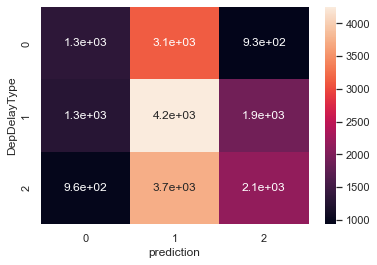

In [531]:
# Matriz de confusión
sns.heatmap(pd.crosstab(test['DepDelayType'], test['prediction']),annot=True)
hm_bayes = pd.DataFrame(metrics.confusion_matrix(test['DepDelayType'],test['prediction']))
hm_bayes

In [532]:
# Accuracy
bayes_accuracy = (test['DepDelayType'] == test['prediction']).mean()
print(bayes_accuracy)

0.3933391047512349


In [533]:
# Cohen Kappa Score
from sklearn.metrics import cohen_kappa_score
bayes_kappa = cohen_kappa_score(test['DepDelayType'],test['prediction'])
print(bayes_kappa)

0.06451451541076492


In [534]:
# Matthew’s correlation coefficient
from sklearn.metrics import matthews_corrcoef
bayes_matthew = matthews_corrcoef(test['DepDelayType'], test['prediction'])
print(bayes_matthew)

0.06735533193156706


## Modelo 2: Naive Bayes

In [535]:
target = 'DepDelayType'
predictors = list(set(df_deps_ATL.columns)-{target})

# NaiveBayes Model
Naive_Model = BayesianNetwork([(target, col) for col in predictors])

# Fit the model
Naive_Model.fit(train)

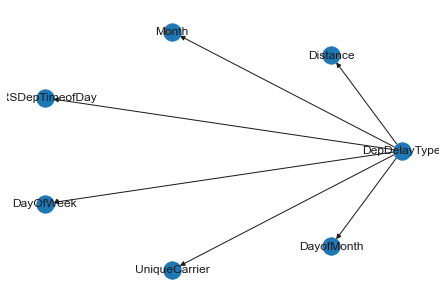

In [536]:
# Model shown
pos = nx.circular_layout(Naive_Model)
nx.draw(Naive_Model, with_labels=True, pos=pos)
plt.show()

In [537]:
# Predicción
test.drop(columns = ['prediction'],inplace=True)
test['prediction'] = Naive_Model.predict(test.drop(columns=['DepDelayType'])).values.ravel()
test.head()

  0%|          | 0/8919 [00:00<?, ?it/s]

,Month,DayofMonth,DayOfWeek,CRSDepTimeofDay,UniqueCarrier,Distance,DepDelayType,prediction
1,1,1,2,1,13,2,0,1
3,1,5,6,3,13,2,2,1
6,1,6,7,1,13,2,2,0
9,1,4,5,3,14,2,0,0
12,1,8,2,0,14,1,0,0


,0,1,2
0,1831,2633,911
1,1363,4001,2059
2,952,3383,2504


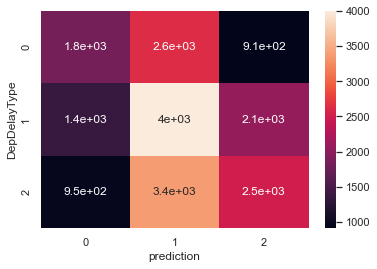

In [538]:
# Matriz de confusión
sns.heatmap(pd.crosstab(test['DepDelayType'], test['prediction']),annot=True)
hm_bayes = pd.DataFrame(metrics.confusion_matrix(test['DepDelayType'],test['prediction']))
hm_bayes

In [539]:
# Accuracy
naive_accuracy = (test['DepDelayType'] == test['prediction']).mean()
print(naive_accuracy)

0.4245047614197688


In [540]:
# Cohen Kappa Score
from sklearn.metrics import cohen_kappa_score
naive_kappa = cohen_kappa_score(test['DepDelayType'],test['prediction'])
print(naive_kappa)

0.1177430815733953


In [541]:
# Matthew’s correlation coefficient
from sklearn.metrics import matthews_corrcoef
naive_matthew = matthews_corrcoef(test['DepDelayType'], test['prediction'])
print(naive_matthew)

0.12022528875895332


## Modelo 3 - Random Forest

In [542]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_deps_ATL.drop(columns = ['DepDelayType']), df_deps_ATL['DepDelayType'], test_size = 0.25, random_state = 42)

In [543]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [544]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 4, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  17.0s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  17.4s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  17.8s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  51.2s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  51.4s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  51.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=60

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=4,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [545]:
rf_random.best_estimator_.fit(X_train, y_train)
# performing predictions on the test dataset
y_pred = rf_random.predict(X_test)
 
# using metrics module for accuracy calculation
rf_accuracy = metrics.accuracy_score(y_test, y_pred)
print(rf_accuracy)

0.4568565142996822


In [546]:
# Cohen Kappa Score
from sklearn.metrics import cohen_kappa_score
rf_kappa = cohen_kappa_score(y_test, y_pred)
print(rf_kappa)

0.1731921375775891


In [547]:
# Matthew’s correlation coefficient
from sklearn.metrics import matthews_corrcoef
rf_matthew = matthews_corrcoef(y_test, y_pred)
print(rf_matthew)

0.1737247445592247


## Comparación de Modelos

In [548]:
np.hstack((met_names,np.hstack((randomforest,np.hstack((bayes,naive))))))

array([['Accuracy', '0.4477', '0.3917', '0.4232'],
       ['Coeficiente de Matthew', '0.1587', '0.062', '0.1186'],
       ['Cohen Kappa', '0.1582', '0.0583', '0.1163']], dtype='<U32')

In [549]:
naive = np.array((round(naive_accuracy,4), round(naive_matthew,4), round(naive_kappa,4))).reshape(3,1)
bayes = np.array((round(bayes_accuracy,4), round(bayes_matthew,4), round(bayes_kappa,4))).reshape(3,1)
randomforest = np.array((round(rf_accuracy,4), round(rf_matthew,4), round(rf_kappa,4))).reshape(3,1)
met_names = np.array(('Accuracy','Coeficiente de Matthew','Cohen Kappa')).reshape(3,1)

met = pd.DataFrame(data = np.hstack((met_names,np.hstack((randomforest,np.hstack((bayes,naive)))))), columns = ['Metric','Random Forest','Bayes','Naive'])
met.head()

,Metric,Random Forest,Bayes,Naive
0,Accuracy,0.4569,0.3933,0.4245
1,Coeficiente de Matthew,0.1737,0.0674,0.1202
2,Cohen Kappa,0.1732,0.0645,0.1177


Text(0.5, 1.0, 'Conclusión por métrica')

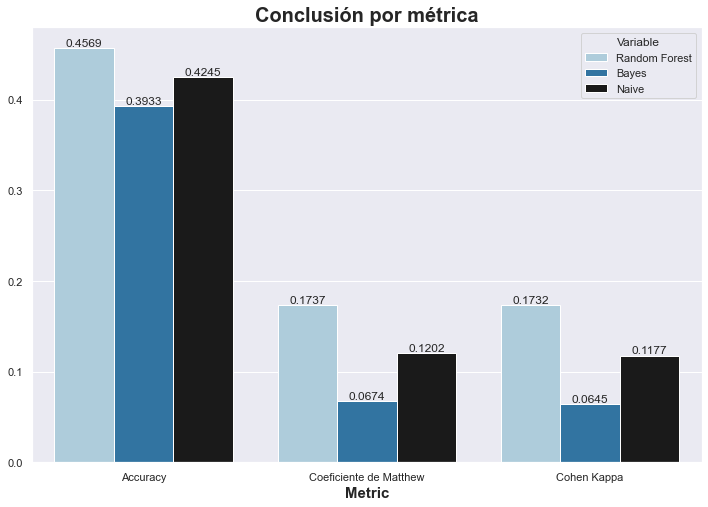

In [550]:
# Accuracy, Matthew Coefficient and Cohen Kappa
import matplotlib.pyplot as plt
sns.set_palette("Paired")
melt_met = met.melt(id_vars = 'Metric').rename(columns=str.title)
melt_met['Value'] = melt_met['Value'].astype(float)

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='Metric', y='Value', hue='Variable', data=melt_met, palette=["C0", "C1", "k"])
for container in ax.containers:
    ax.bar_label(container)
ax.set_xlabel("Metric",fontsize = 15, fontweight = 'bold')
ax.set_ylabel('')
ax.set_title('Conclusión por métrica',fontsize = 20, fontweight = 'bold')

**Puntos a recalcar para la conclusión:**
- El mejor modelo para todas las métricas fue Random Forest
- Bajo números para las métricas
- Variables antes de un despegue.
- Variables insuficientes.
    - Variables climáticas:
        - Presión atmosférica
        - Viento
        - Velocidad del viento
        - Humedad
        - Temperatura
    - Conexiones
    - Número de pasajeros
- Tiempo de ejecución
    - Optimización de hiperparámetros
    - Preprocesamiento de datos
- Más datos en la red Bayesiana
- Naive, independencia entre variables.
- Mismo modelo, nuevas variables